# E Prime Conservation for GPU vs CPU
### Unperturbed Tracing:

For unperturbed tracing, we analyze $E$ and $P_\zeta$, as both should be conserved.

[login21:1866427] mca_base_component_repository_open: unable to open mca_btl_openib: /usr/lib64/libnl-3.so.200: version `libnl_3_5' not found (required by /global/homes/b/billert/.conda/envs/testing_cuda_compiler/lib/openmpi/.././libnl-route-3.so.200) (ignored)


CPU: Unperturbed Energy conserved to  6.2274725449645265  digits
CPU: Unperturbed Pzeta conserved to  5.598480926533648  digits

GPU: Unperturbed Energy conserved to  6.256492600236512  digits
GPU: Unperturbed Pzeta conserved to  5.634933239029304  digits


Text(0.5, 0, 'time (microseconds)')

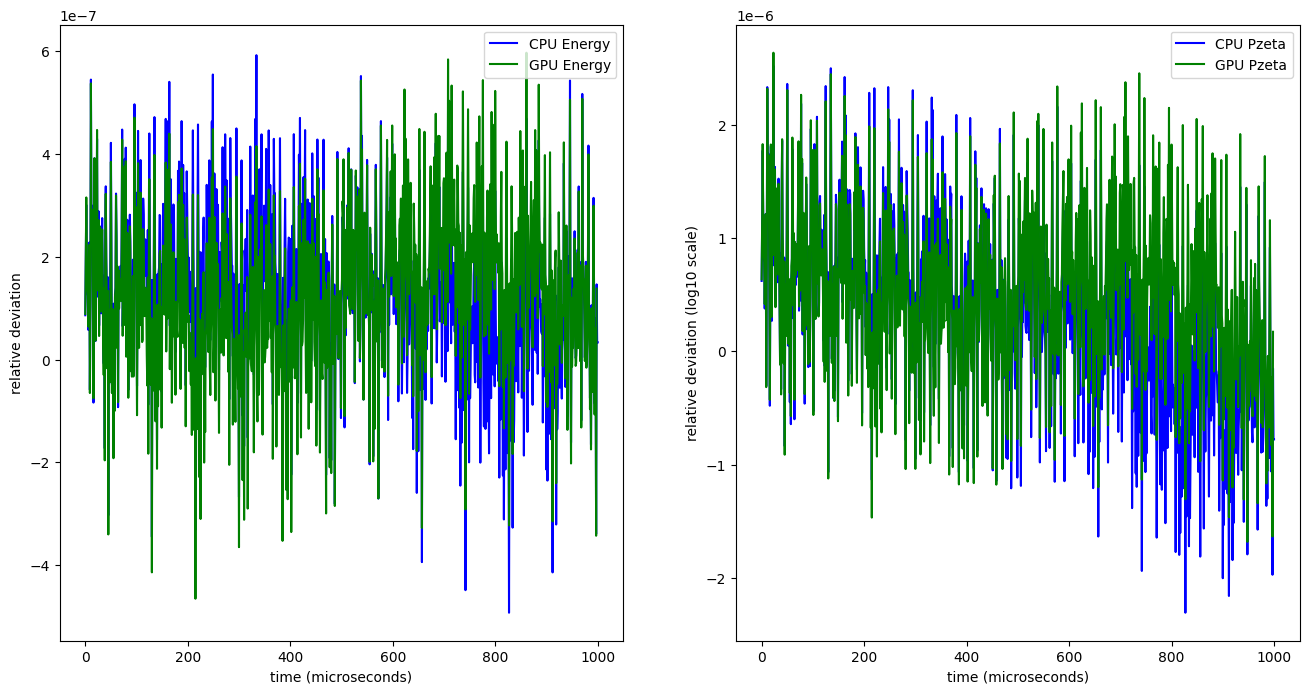

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from simsopt.field.boozermagneticfield import (
        BoozerRadialInterpolant,
        InterpolatedBoozerField,
        ShearAlfvenHarmonic,
        ShearAlfvenWavesSuperposition
        )
from simsopt.util.constants import (
        ALPHA_PARTICLE_MASS as MASS,
        ALPHA_PARTICLE_CHARGE as CHARGE,
        FUSION_ALPHA_PARTICLE_ENERGY as ENERGY
)
from booz_xform import Booz_xform
from stellgap import AE3DEigenvector, saw_from_ae3d
import stellgap as sg


cpu_unperturbed_traj = np.loadtxt("vac_traced_cpu_1e-10_15_unpeturbed")
gpu_unperturbed_traj = np.loadtxt("vac_traced_gpu_1e-10_15_unpeturbed")


# set this to zero for unperturbed
phihat_amplitude = 0

filename = 'boozmn_precise_QH.nc'
saw_filename = "mode/1st.npy"

equil = Booz_xform()
equil.verbose = 0
equil.read_boozmn(filename)
nfp = equil.nfp
helicity = -1
# this is consistent with QH

eigenvector = AE3DEigenvector.load_from_numpy(filename=saw_filename)
omega = np.sqrt(eigenvector.eigenvalue)*1000

# we traced with 15 resolution, so we analyze with 15 resolution too.

resolution = 15

bri = BoozerRadialInterpolant(
    equil=equil,
    order=3,
    no_K=False,
    N = nfp * -1
)

field = InterpolatedBoozerField(
        field=bri,
        degree=3,
        srange=(0, 1, resolution),
        thetarange=(0, np.pi, resolution),
        zetarange=(0, 2 * np.pi / nfp, resolution),
        extrapolate=True,
        nfp=nfp,
        stellsym=True,
        initialize=['modB','modB_derivs']
)



harmonic_list = []
for harmonic in eigenvector.harmonics:
    sbump = eigenvector.s_coords
    bump = harmonic.amplitudes
    sah = ShearAlfvenHarmonic(
        Phihat_value_or_tuple=(sbump, phihat_amplitude*bump),
        Phim=harmonic.m,
        Phin=harmonic.n,
        omega=omega,
        phase=0.0,
        B0=field
    )
    harmonic_list.append(sah)
saw = ShearAlfvenWavesSuperposition(harmonic_list)

Phim=eigenvector.harmonics[0].m
Phin=eigenvector.harmonics[0].n

# compute MU for energy calculation

VELOCITY = np.sqrt(2*ENERGY/MASS)
saw.B0.set_points([cpu_unperturbed_traj[0, 1:4]])
vpar_init = cpu_unperturbed_traj[0][4]
MU = MASS * (VELOCITY**2 - vpar_init**2) / (2 * saw.B0.modB()[:,0])

def saw_Pzeta_Eprime_calc(saw,points,vpar):
    saw.set_points(points)
    modB = saw.B0.modB()[:,0]
    G = saw.B0.G()[:,0]
    # enforce vaccuum condition I = 0
    I = 0
    psi = saw.B0.psi0 * points[:, 0]
    psip = saw.B0.psip()[:,0]
    alpha = saw.alpha()[:,0]
    phi = saw.Phi()[:,0]

    Energy = 0.5*MASS*vpar**2 + MU * modB + CHARGE*phi
    # print(vpar, modB, CHARGE*phi)

    Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
    # Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
    

    Eff = (Phin-helicity*nfp*Phim)*Energy-omega*Pzeta
    return Energy,Pzeta,Eff


# reshape order of trajectory coordinates to fit with saw.set_points function

unperturbed_cpu_points = np.zeros(np.shape(cpu_unperturbed_traj[:, :4]))
unperturbed_cpu_points[:, 0] = cpu_unperturbed_traj[:, 1]
unperturbed_cpu_points[:, 1] = cpu_unperturbed_traj[:, 2]
unperturbed_cpu_points[:, 2] = cpu_unperturbed_traj[:, 3]
unperturbed_cpu_points[:, 3] = cpu_unperturbed_traj[:, 0]
unperturbed_cpu_vpar = cpu_unperturbed_traj[:, 4]

unperturbed_gpu_points = np.zeros(np.shape(gpu_unperturbed_traj[:, :4]))
unperturbed_gpu_points[:, 0] = gpu_unperturbed_traj[:, 0]
unperturbed_gpu_points[:, 1] = gpu_unperturbed_traj[:, 1]
unperturbed_gpu_points[:, 2] = gpu_unperturbed_traj[:, 2]
unperturbed_gpu_points[:, 3] = gpu_unperturbed_traj[:, 4]
unperturbed_gpu_vpar = gpu_unperturbed_traj[:, 3]


unperturbed_cpu_E, unperturbed_cpu_Pz, unperturbed_cpu_Ep = saw_Pzeta_Eprime_calc(saw, unperturbed_cpu_points, unperturbed_cpu_vpar)
unperturbed_gpu_E, unperturbed_gpu_Pz, unperturbed_gpu_Ep = saw_Pzeta_Eprime_calc(saw, unperturbed_gpu_points, unperturbed_gpu_vpar)

print("CPU: Unperturbed Energy conserved to ", -np.log10(np.max(np.abs((unperturbed_cpu_E - unperturbed_cpu_E[0])/unperturbed_cpu_E[0]))), " digits")
print("CPU: Unperturbed Pzeta conserved to ", -np.log10(np.max(np.abs((unperturbed_cpu_Pz - unperturbed_cpu_Pz[0])/unperturbed_cpu_Pz[0]))), " digits")
print()
print("GPU: Unperturbed Energy conserved to ", -np.log10(np.max(np.abs((unperturbed_gpu_E - unperturbed_gpu_E[0])/unperturbed_cpu_E[0]))), " digits")
print("GPU: Unperturbed Pzeta conserved to ", -np.log10(np.max(np.abs((unperturbed_gpu_Pz - unperturbed_gpu_Pz[0])/unperturbed_cpu_Pz[0]))), " digits")


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].plot(((unperturbed_cpu_E[1:] - unperturbed_cpu_E[0])/unperturbed_cpu_E[0]), color="blue", label="CPU Energy")
axes[0].plot(((unperturbed_gpu_E - unperturbed_cpu_E[0])/unperturbed_cpu_E[0]), color="green", label = "GPU Energy")
axes[0].legend(loc="upper right")
axes[0].set_ylabel("relative deviation")
axes[0].set_xlabel("time (microseconds)")
axes[1].plot(((unperturbed_cpu_Pz[1:] - unperturbed_cpu_Pz[0])/unperturbed_cpu_Pz[0]), color="blue", label="CPU Pzeta")
axes[1].plot(((unperturbed_gpu_Pz - unperturbed_cpu_Pz[0])/unperturbed_cpu_Pz[0]), color="green", label = "GPU Pzeta")
axes[1].legend(loc="upper right")
axes[1].set_ylabel("relative deviation (log10 scale)")
axes[1].set_xlabel("time (microseconds)")


### Perturbed Tracing

We look at $\overline{E}_n$ conservation over a period of $1$ millisecond.

In [2]:
res = 15
tol = 1e-10
amplitudes = [1, 10, 1000, 10000]

for amplitude in amplitudes:
    phihat_amplitude = amplitude
    harmonic_list = []
    for harmonic in eigenvector.harmonics:
        sbump = eigenvector.s_coords
        bump = harmonic.amplitudes
        sah = ShearAlfvenHarmonic(
            Phihat_value_or_tuple=(sbump, phihat_amplitude*bump),
            Phim=harmonic.m,
            Phin=harmonic.n,
            omega=omega,
            phase=0.0,
            B0=field
        )
        harmonic_list.append(sah)
        saw = ShearAlfvenWavesSuperposition(harmonic_list)
    cpu_perturbed_traj = np.loadtxt(f"vac_traced_cpu_1e-10_15_{amplitude}")
    gpu_perturbed_traj = np.loadtxt(f"vac_traced_gpu_1e-10_15_{amplitude}")
    
    perturbed_cpu_points = np.zeros(np.shape(cpu_perturbed_traj[:, :4]))
    perturbed_cpu_points[:, 0] = cpu_perturbed_traj[:, 1]
    perturbed_cpu_points[:, 1] = cpu_perturbed_traj[:, 2]
    perturbed_cpu_points[:, 2] = cpu_perturbed_traj[:, 3]
    perturbed_cpu_points[:, 3] = cpu_perturbed_traj[:, 0]
    perturbed_cpu_vpar = cpu_perturbed_traj[:, 4]
    
    perturbed_gpu_points = np.zeros(np.shape(gpu_perturbed_traj[:, :4]))
    perturbed_gpu_points[:, 0] = gpu_perturbed_traj[:, 0]
    perturbed_gpu_points[:, 1] = gpu_perturbed_traj[:, 1]
    perturbed_gpu_points[:, 2] = gpu_perturbed_traj[:, 2]
    perturbed_gpu_points[:, 3] = gpu_perturbed_traj[:, 4]
    perturbed_gpu_vpar = gpu_perturbed_traj[:, 3]
    
    
    perturbed_cpu_E, perturbed_cpu_Pz, perturbed_cpu_Ep = saw_Pzeta_Eprime_calc(saw, perturbed_cpu_points, perturbed_cpu_vpar)
    perturbed_gpu_E, perturbed_gpu_Pz, perturbed_gpu_Ep = saw_Pzeta_Eprime_calc(saw, perturbed_gpu_points, perturbed_gpu_vpar)
    
    print(f"CPU: perturbed Eprime (amplitude {amplitude})  conserved to ", -np.log10(np.max(np.abs((perturbed_cpu_Ep - perturbed_cpu_Ep[0])/perturbed_cpu_Ep[0]))), " digits")
    print(f"GPU: perturbed Eprime (amplitude {amplitude}) conserved to ", -np.log10(np.max(np.abs((perturbed_gpu_Ep - perturbed_gpu_Ep[0])/perturbed_cpu_Ep[0]))), " digits")
    print()
    

CPU: perturbed Eprime (amplitude 1)  conserved to  6.042184326469102  digits
GPU: perturbed Eprime (amplitude 1) conserved to  6.103358676032569  digits

CPU: perturbed Eprime (amplitude 10)  conserved to  6.200727558534115  digits
GPU: perturbed Eprime (amplitude 10) conserved to  6.149319877048965  digits

CPU: perturbed Eprime (amplitude 1000)  conserved to  6.09523392927959  digits
GPU: perturbed Eprime (amplitude 1000) conserved to  6.232411230300946  digits

CPU: perturbed Eprime (amplitude 10000)  conserved to  5.953122926357544  digits
GPU: perturbed Eprime (amplitude 10000) conserved to  6.108708818078451  digits



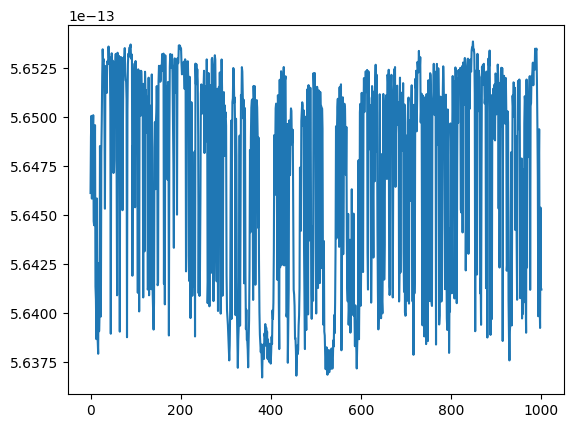

In [3]:
plt.plot(perturbed_cpu_E)

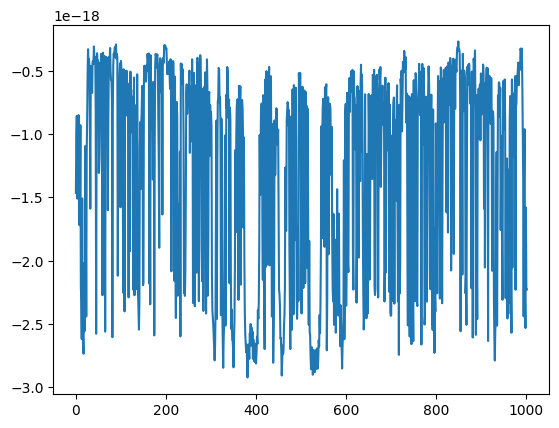

In [4]:
plt.plot(perturbed_cpu_Pz)